<a href="https://colab.research.google.com/github/maverick98/Group4Capstone/blob/main/image_caption_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uncomment the below cells if you are running for the first time

In [ ]:
COLLAB=True



In [ ]:
if COLLAB == True:
  from google.colab import drive
  drive.mount('/content/drive')
  

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/Capstone

In [ ]:
!wget  https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
#!cp /content/Flickr8k_Dataset.zip /content/drive/MyDrive/Capstone
#!cp /content/Flickr8k_text.zip /content/drive/MyDrive/Capstone

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-03-18 08:13:29--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-18 08:13:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.90MB/s    in 2m 39s  

2023-03-18 08:16:08 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!mkdir -p ./data/glove
!unzip  ./glove.6B.zip -d /content/data/glove

Archive:  ./glove.6B.zip
  inflating: /content/data/glove/glove.6B.50d.txt  
  inflating: /content/data/glove/glove.6B.100d.txt  
  inflating: /content/data/glove/glove.6B.200d.txt  
  inflating: /content/data/glove/glove.6B.300d.txt  


In [ ]:
#!ls /content/drive/MyDrive/Capstone
!mkdir -p ./data/images
!mkdir -p ./data/texts
#!cp /content/drive/MyDrive/Capstone/Flickr8k_Dataset.zip  /content/data/images
#!cp /content/drive/MyDrive/Capstone/Flickr8k_text.zip /content/data/texts

In [ ]:
!unzip  ./Flickr8k_text.zip -d ./data/texts

In [ ]:
!unzip  ./Flickr8k_Dataset.zip -d /content/data/images



In [ ]:

#!pip install keras
!pip install gensim
!pip install python-levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.4 MB/s eta 0:00:00


In [326]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector
from keras.layers import Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
#from tensorflow.keras.layers.wrappers import Bidirectional
#from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
#from tf.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
import gensim
import random
import time
     


In [ ]:
random.choices(range(0,50),k=6)

[3, 31, 47, 44, 1, 47]

In [329]:
class CNNModel:
    def __init__(self,image_path, **kwargs):
        super().__init__(**kwargs)
        self.model=None
        self.image_path=image_path
          
    def load_model(self):
        # Load the inception v3 model
        model = InceptionV3(weights='imagenet')
        # Create a new model, by removing the last layer (output layer) from the inception v3
        self.model = Model(model.input, model.layers[-2].output)
        return self.model
    def show_summary(self):
        print(self.model.summary() )
    def preprocess(self,image):
        # Convert all the images to size 299x299 as expected by the inception v3 model
        #img = Image.load_img(image_path, target_size=(299, 299))
        img=Image.open(image)
        img = img.resize((299, 299))
        # Convert PIL image to numpy array of 3-dimensions
        x = tf.keras.utils.img_to_array(img)
        # Add one more dimension
        x = np.expand_dims(x, axis=0)
        # preprocess the images using preprocess_input() from inception module
        x = preprocess_input(x)
        return x
    # Function to encode a given image into a vector of size (2048, )
    def encode(self,image):
        image = self.preprocess(image) # preprocess the image
        fea_vec = self.model.predict(image) # Get the encoding vector for the image
        fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
        return fea_vec
    # Call the funtion to encode all the train images
    # This will take a while on CPU - Execute this only once
    def encode_images(self,imgs):
        
        start = time.time()
        encoding_imgs = {}
        count=0;
        for img in imgs:
            count=count+1
            encoding_imgs[img[len(self.image_path):]] = self.encode(img)
            #print('Processed image ',count)
        print("Time taken in seconds =", time.time()-start)
        return encoding_imgs
    def save_encoded_imgs(self,images_pkl_file,encoded_images):
        # Save the bottleneck train features to disk
        with open(images_pkl_file, "wb") as encoded_pickle:
            dump(encoded_images, encoded_pickle)             


In [330]:
class DatasetInput:
      def __init__(self,**kwargs):
          super().__init__(**kwargs)
      def set_cnn_model(self,value):
          self.cnn_model=value
          return self
      def set_image_path(self,value):
          self.image_path=value
          return self
      def set_token_file(self,value):
          self.token_file=value
          return self
      def set_train_images_text_file(self,value):
          self.train_images_text_file=value
          return self
      def set_dev_images_text_file(self,value):
          self.dev_images_text_file=value
          return self
      def set_test_images_text_file(self,value):
          self.test_images_text_file=value
          return self    
      def set_descriptions_file(self,value):
          self.descriptions_file=value
          return self   
      def set_encoded_train_images_pkl(self,value):
          self.encoded_train_images_pkl=value
          return self 
      def set_encoded_dev_images_pkl(self,value):
          self.encoded_dev_images_pkl=value
          return self 
      def set_encoded_test_images_pkl(self,value):
          self.encoded_test_images_pkl=value
          return self
      def set_data_limit(self,value):
          self.data_limit=value
          return self                                         


In [346]:
class ImageCaptionDataset:
      def __init__(self,datasetInput, **kwargs):
           super().__init__(**kwargs)
           self.datasetInput=datasetInput
           self.tokens=None
           self.vocabulary=None
           self.all_images=None
      def show_random_images(self,how_many):
          all_images = glob(self.datasetInput.image_path + "*.jpg")
          rnd_images=random.choices(range(0,len(all_images)),k=how_many)
          for i in rnd_images:
              plt.figure()
              image = cv2.imread(all_images[i])
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              plt.imshow(image)
      def load_descriptions(self):
            with open(self.datasetInput.token_file) as f:
                data = f.read()
            # dictionary contining key as image_id and value as list of captions.
            self.descriptions = dict()
            try:
                for line in data.split("\n"):
                    tokens = line.split()
                    image_id , image_desc = tokens[0],tokens[1:]
                    
                    image_id = image_id.split(".")[0]
                    image_desc = " ".join(image_desc)
                    
                    if image_id in self.descriptions:
                        self.descriptions[image_id].append(image_desc)
                    else:
                        self.descriptions[image_id] = list()
                        self.descriptions[image_id].append(image_desc)
                    

            except Exception as e: 
                print("Exception got :- \n",e)
            return   self.descriptions
      def clean_descriptions(self):
            # prepare translation table for removing punctuation
            table = str.maketrans('', '', string.punctuation)
            for key, desc_list in self.descriptions.items():
                for i in range(len(desc_list)):
                    desc = desc_list[i]
                    # tokenize
                    desc = desc.split()
                    # convert to lower case
                    desc = [word.lower() for word in desc]
                    # remove punctuation from each token
                    desc = [w.translate(table) for w in desc]
                    # remove hanging 's' and 'a'
                    desc = [word for word in desc if len(word)>1]
                    # remove tokens with numbers in them
                    desc = [word for word in desc if word.isalpha()]
                    # store as string
                    desc_list[i] =  ' '.join(desc)                 
     
      # load clean descriptions into memory
      def load_clean_descriptions(self,dataset):
            # load document
            file_content = self.load_file(self.datasetInput.descriptions_file)
            #print(file_content)
            descriptions = dict()
            for line in file_content.split('\n'):
                #print(line)
                # split line by white space
                tokens = line.split()
                # split id from description
                image_id, image_desc = tokens[0], tokens[1:]
                #print('image_id',image_id)
                #print('image_desc',image_desc)
                # skip images not in the set
                #print('image_data_path',self.get_image_path(image_id,self.image_path))
                if self.get_image_path(image_id,self.datasetInput.image_path) in dataset:
                    # create list
                    if image_id not in descriptions:
                        descriptions[image_id] = list()
                    # wrap description in tokens
                    desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
                    # store
                    descriptions[image_id].append(desc)
            return descriptions               
      # convert the loaded descriptions into a vocabulary of words
      def build_vocabulary(self):
            # build a list of all description strings
            vocabulary = set()
            for key in self.descriptions.keys():
                [vocabulary.update(d.split()) for d in self.descriptions[key]]
            self.vocabulary=vocabulary
            print('Original Vocabulary Size: %d' % len(self.vocabulary))    
            return vocabulary
      # save descriptions to file, one per line
      def save_descriptions(self):
            lines = list()
            for key, desc_list in self.descriptions.items():
                for desc in desc_list:
                    lines.append(key + ' ' + desc)
            data = '\n'.join(lines)
            file = open(self.datasetInput.descriptions_file, 'w')
            file.write(data)
            file.close()
      
      # convert a dictionary of clean descriptions to a list of descriptions
      def convert_descriptions_to_lines(self):
            all_desc = list()
            for key in self.descriptions.keys():
                [all_desc.append(d) for d in self.descriptions[key]]
            self.descriptions_lines=all_desc    
            return self.descriptions_lines

      # calculate the length of the description with the most words
      def get_descriptions_max_len(self):
            lines = self.convert_descriptions_to_lines()
            self.descriptions_max_len=max(len(d.split()) for d in lines)
            return self.descriptions_max_len

       
      
      # load doc into memory
      def load_file(self,filename):
            # open the file as read only
            file = open(filename, 'r')
            # read all text
            text = file.read()
            # close the file
            file.close()
            return text
      def get_image_path(self,img, image_dataset_path):
            return image_dataset_path+img+'.jpg'      

      # load a pre-defined list of photo identifiers
      def load_set(self,filename):
            doc = self.load_file(filename)
            dataset = list()
            # process line by line
            for line in doc.split('\n'):
                # skip empty lines
                if len(line) < 1:
                    continue
                # get the image identifier
                identifier = line.split('.')[0]
                dataset.append(identifier)
            return set(dataset)
      # Create a list of all image names in the directory
      def load_all_images(self):
            self.all_images = glob(self.datasetInput.image_path + '*.jpg')
            return self.all_images
      

      def process_tokens(self):
          self.load_descriptions()
          self.clean_descriptions()
          self.build_vocabulary()
          self.save_descriptions()
      # Below file conatains the names of images to be used in train data  
      def load_train_test_imgs(self,train_test_images_file):
            if self.all_images == None:
                self.load_all_images()
            # Read the train image names in a set
            train_test_images = set(open(train_test_images_file, 'r').read().strip().split('\n'))
            #print(train_test_images)
            # Create a list of all the training images with their full path names
            train_test_img = []
            
            for i in self.all_images: # img is list of full path names of all images
                #train_test_img.append(i)
                if i[len(self.datasetInput.image_path):] in train_test_images: # Check if the image belongs to training set
                    train_test_img.append(i) # Add it to the list of train images
            return train_test_img
      def load_train_imgs(self):
          self.train_imgs=self.load_train_test_imgs(self.datasetInput.train_images_text_file)
          print('Train imgs Size: %d' % len(self.train_imgs))    
      def load_dev_imgs(self):
          self.dev_imgs=self.load_train_test_imgs(self.datasetInput.dev_images_text_file)
          print('Dev imgs Size: %d' % len(self.dev_imgs))    
      def load_test_imgs(self):
          self.test_imgs=self.load_train_test_imgs(self.datasetInput.test_images_text_file) 
          print('Test imgs Size: %d' % len(self.test_imgs))
      def encode_train_images(self):
          self.encoded_train_images=self.datasetInput.cnn_model.encode_images(self.train_imgs)
      def encode_dev_images(self):
          self.encoded_dev_images=self.datasetInput.cnn_model.encode_images(self.dev_imgs)
      def encode_test_images(self):
          self.encoded_test_images=self.datasetInput.cnn_model.encode_images(self.test_imgs)
      def save_encoded_train_images(self):
          self.datasetInput.cnn_model.save_encoded_imgs(self.datasetInput.encoded_train_images_pkl,self.encoded_train_images)     
      def save_encoded_dev_images(self):
          self.datasetInput.cnn_model.save_encoded_imgs(self.datasetInput.encoded_dev_images_pkl,self.encoded_dev_images)    
      def save_encoded_test_images(self):
          self.datasetInput.cnn_model.save_encoded_imgs(self.datasetInput.encoded_test_images_pkl,self.encoded_test_images)

      def load_cnn_model(self):
          self.datasetInput.cnn_model.load_model()
      def show_cnn_model(self):
          self.datasetInput.cnn_model.show_summary()                             

     
     
                                                                                 

In [332]:
image_path = "./data/images/Flicker8k_Dataset/"
token_file='./data/texts/Flickr8k.token.txt'

train_images_text_file='./data/texts/Flickr_8k.trainImages.txt'
dev_images_text_file='./data/texts/Flickr_8k.devImages.txt'
test_images_text_file='./data/texts/Flickr_8k.testImages.txt'
descriptions_file='./descriptions.txt'
data_limit=100

encoded_train_images_pkl='./encoded_train_images.pkl'
encoded_dev_images_pkl='./encoded_dev_images.pkl'
encoded_test_images_pkl='./encoded_test_images.pkl'

In [347]:
cnn_model=CNNModel(image_path)


In [348]:
datasetInput=DatasetInput()
datasetInput.set_cnn_model(cnn_model)\
            .set_image_path(image_path)\
            .set_token_file(token_file)\
            .set_train_images_text_file(train_images_text_file)\
            .set_dev_images_text_file(dev_images_text_file)\
            .set_test_images_text_file(test_images_text_file)\
            .set_descriptions_file(descriptions_file)\
            .set_data_limit(data_limit)\
            .set_encoded_train_images_pkl(encoded_train_images_pkl)\
            .set_encoded_dev_images_pkl(encoded_dev_images_pkl)\
            .set_encoded_test_images_pkl(encoded_test_images_pkl)
print(datasetInput.cnn_model)     

In [352]:
imageCaptionDataset= ImageCaptionDataset(datasetInput)

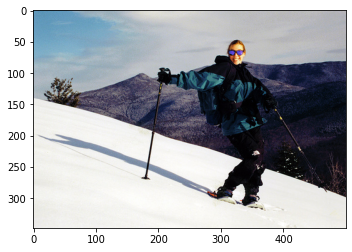

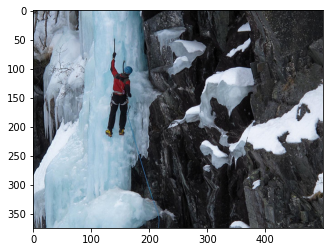

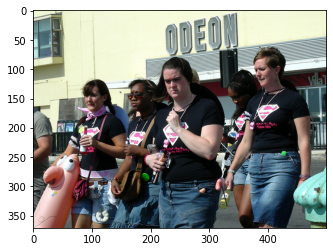

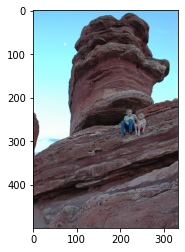

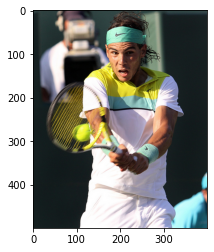

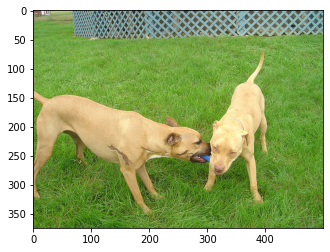

In [353]:

imageCaptionDataset.show_random_images(6)

This loads token files and returns  a map

In [354]:
imageCaptionDataset.process_tokens()
imageCaptionDataset.load_train_imgs()
imageCaptionDataset.load_test_imgs()


Exception got :- 
 list index out of range
Original Vocabulary Size: 8763
Train imgs Size: 6000
Test imgs Size: 1000


In [355]:
# descriptions
train_descriptions = imageCaptionDataset.load_clean_descriptions(imageCaptionDataset.train_imgs)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [356]:
imageCaptionDataset.load_cnn_model()

In [ ]:
imageCaptionDataset.show_cnn_model()

In [363]:
imageCaptionDataset.encode_train_images()

In [ ]:
imageCaptionDataset.save_encoded_train_images()

In [365]:
imageCaptionDataset.encode_test_images()

In [364]:
imageCaptionDataset.save_encoded_test_images()

In [ ]:
train_features = load(open(encoded_train_images_pkl, "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=1


In [ ]:


# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)



30000

In [ ]:


# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))



preprocessed words 7578 -> 1651


In [ ]:
vocab

In [ ]:


ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1



In [ ]:


vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size



1652

Description Length: 34


In [ ]:


# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
   
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0



Run it for the first time

Run it for the first time

In [ ]:


# Load Glove vectors
glove_dir = './data/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))



Found 400000 word vectors.


In [ ]:


embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector



In [ ]:


embedding_matrix.shape



(1652, 300)

In [ ]:


inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = tf.keras.layers.Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)



In [ ]:
model.summary()

In [ ]:


model.layers[2]



In [ ]:


model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False



In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:


for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/model_weights/model_' + str(i) + '.h5')



In [ ]:
model.load_weights('./model_weights/model_10.h5')

In [ ]:


def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final



In [ ]:
with open(encoded_test_images_pkl, "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:


z=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(image_dataset+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))



In [ ]:
z=10
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(image_dataset+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

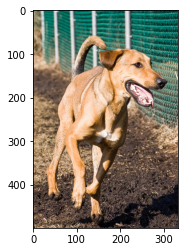

Greedy: brown dog is running through the grass


In [ ]:
z=100
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(image_dataset+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

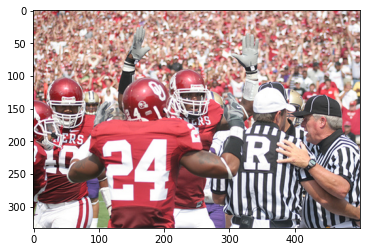

Greedy: two football teams are in action


In [ ]:
z=811
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(image_dataset+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))